In [374]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Modal Regression
### Or, how I learned a lot about the wrong method

## A Concise Example

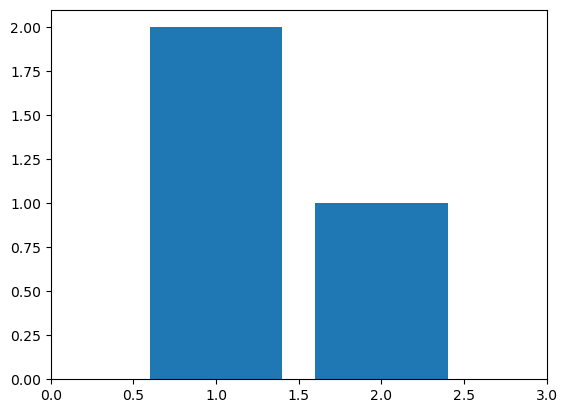

In [375]:
d = [1,1,2]
labels, counts = np.unique(d, return_counts=True)

plt.bar(labels, counts, align='center')
plt.xlim(0,3)
plt.show()

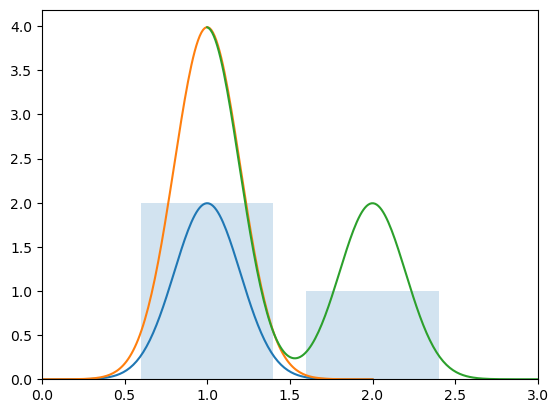

In [376]:
x0 = np.linspace(-1,1,200)
y0 = stats.norm.pdf(x0,0,0.2) # <-gaussian kernel
l = len(y0)
l5 = int(l/2)

x1 = [i+1 for i in x0]
x2 = x1
x3 = [i+2 for i in x0]

y1 = y0
y2 = [i+i for i in y0]
y3 = [y2[i+l5]+y0[i] for i in range(l5)] + [i for i in y0[l5:]]

plt.bar(labels, counts, align='center', alpha=0.2)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x3,y3)

plt.xlim(0,3)
plt.show()

## Exploring Bandwidth

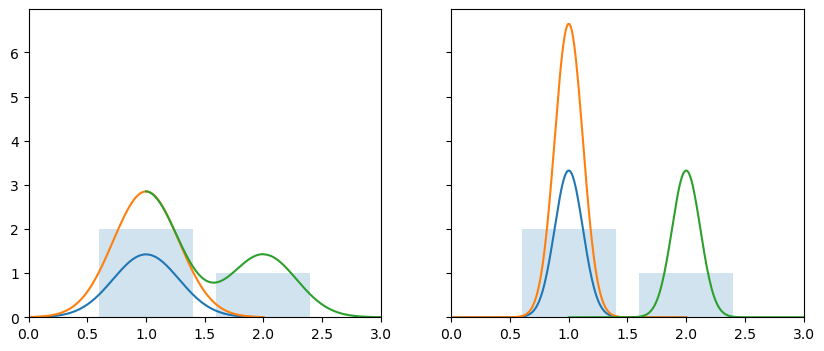

In [377]:
x0 = np.linspace(-1,1,200)
y0 = stats.norm.pdf(x0,0,0.28) # <- Increased the spread: higher bandwidth
l = len(y0)
l5 = int(l/2)

x1 = [i+1 for i in x0]
x2 = x1
x3 = [i+2 for i in x0]

y1 = y0
y2 = [i+i for i in y0]
y3 = [y2[i+l5]+y0[i] for i in range(l5)] + [i for i in y0[l5:]]


fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)

ax[0].bar(labels, counts, align='center', alpha=0.2)
ax[0].plot(x1,y1)
ax[0].plot(x2,y2)
ax[0].plot(x3,y3)
ax[0].set_xlim(0,3)


x0 = np.linspace(-1,1,200)
y0 = stats.norm.pdf(x0,0,0.12) # <- Decreased the spread: lower bandwidth
l = len(y0)
l5 = int(l/2)

x1 = [i+1 for i in x0]
x2 = x1
x3 = [i+2 for i in x0]

y1 = y0
y2 = [i+i for i in y0]
y3 = y0

ax[1].bar(labels, counts, align='center', alpha=0.2)
ax[1].plot(x1,y1)
ax[1].plot(x2,y2)
ax[1].plot(x3,y3)
ax[1].set_xlim(0,3)

plt.show()

# Helper Functions

In [378]:
def mirror_2d(x,y, axis=0): #axis = 0 for X, axis=1 for Y
    target_var = x if axis==0 else y
    unaffected_var = y if axis==0 else x
    range_max = min(target_var)
    target_var = [(i * -1) for i in target_var]
    range_min = max(target_var)
    range = range_max-range_min
    target_var = [i+range for i in target_var]
    if axis == 0:
        return target_var, unaffected_var
    else: return unaffected_var, target_var

def mirror_2d_on0(x,y, axis=0): #axis = 0 for X, axis=1 for Y
    target_var = x if axis==0 else y
    unaffected_var = y if axis==0 else x
    range_max = min(target_var)
    target_var = [(i * -1) for i in target_var]
    if axis == 0:
        return target_var, unaffected_var
    else: return unaffected_var, target_var

def extract_trendline(x,y,z):
    xs, ys = [], []
    for i in range(len(z)):
        for j in range(len(z[i])):
            if z[i][j] == 1.0:
                xs.append(x[i][j])
                ys.append(y[i][j])
    return xs, ys

def normalize_cols(Z, type='minmax'):
    Z_df = pd.DataFrame(Z)
    if type == 'minmax':
        for col in Z_df.columns:
            max_val = Z_df[col].max()
            min_val = Z_df[col].min()
            Z_df[col] = (Z_df[col]-min_val) / (max_val-min_val)
    elif type == 'density':
        for col in Z_df.columns:
            Z_df[col] = [i/Z_df[col].sum() for i in Z_df[col]]
            zmax = Z_df[col].max()
            Z_df[col] = [i/zmax if i>0 else 0 for i in Z_df[col]]
    return Z_df

def get_kde_matrices(df, x_var, y_var, x_fid, y_fid, pad, forced_y_max = False):
    if pad > 0:
        pad_ratio = 1/pad
    else:
        pad_ratio = 1
    min_f = df[y_var].min()
    if forced_y_max:
        max_f = forced_y_max
    else:
        max_f = df[y_var].max()
    f_range = abs(max_f-min_f)
    min_f -= f_range / (pad_ratio)
    max_f += f_range / (pad_ratio)
    min_p = df[x_var].min()
    max_p = df[x_var].max()
    p_range = abs(max_p-min_p)
    min_p -= p_range / (pad_ratio)
    max_p += p_range / (pad_ratio)
    X, Y = np.mgrid[min_p:max_p:x_fid, min_f:max_f:y_fid]
    positions = np.vstack([X.ravel(), Y.ravel()])
    x_array = df[x_var].tolist()
    y_array = df[y_var].tolist()
    return X, Y, x_array, y_array, positions

def generate_KDE_adj_w(bw, X, Y, W, x_array, y_array, positions, boundary=False, normalize=False, contrast_trend=False):
    y_array
    values = np.vstack([x_array, y_array])
    kernel = stats.gaussian_kde(values, bw_method=bw, weights=list(W))
    Z = np.reshape(kernel(positions).T, X.shape)
    if boundary:
        x2_array, y2_array = mirror_2d_on0(x_array,y_array, axis=1)
        values2 = np.vstack([x2_array, y2_array])
        kernel = stats.gaussian_kde(values2, bw_method=bw)
        Z2 = np.reshape(kernel(positions).T, X.shape)
        Z = Z+Z2
    if normalize:
        Z_df = normalize_cols(Z.T, type='density')
        Z = Z_df.to_numpy()
        Z = Z.T
    trend = extract_trendline(X,Y,Z)
    if normalize & contrast_trend:
        Z[Z==Z.max()] = 0.5
    return X, Y, Z, trend

def apply_reg(x, b0, b1):
    y = [b0+b1*i for i in x]
    return y

# Bivariate Examples
## Regression Explanation

In [379]:
# KDE parameters for helper functions
x_resolution = 200j
y_resolution = 200j
norm_plot = True
contrast_trend = True

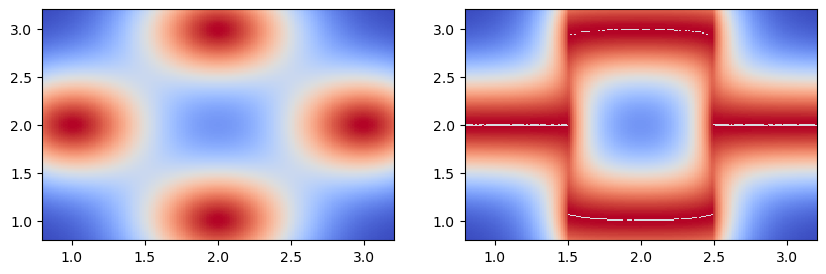

In [380]:
df = pd.DataFrame({'x':[1,2,2,3], 'y':[2,1,3,2], 'w':[1,1,1,1]})

bandwidth = 0.5

fig, ax = plt.subplots(1,2, figsize=(10,3), facecolor='white')

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y', x_resolution, y_resolution, 0.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['w'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y', x_resolution, y_resolution, 0.1,)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['w'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

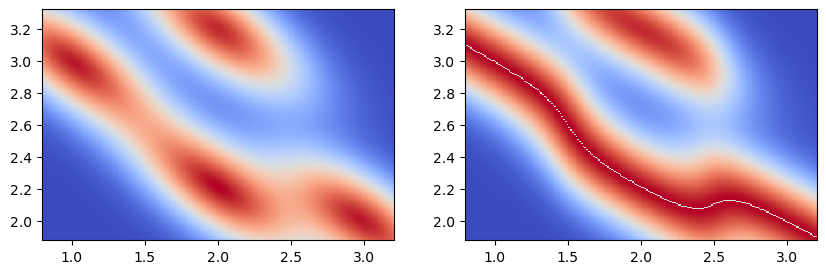

In [381]:
df = pd.DataFrame({'x':[1,2,2,3], 'y':[3,2.2,3.2,2], 'w':[1,1,1,1]})

bandwidth = 0.5

fig, ax = plt.subplots(1,2, figsize=(10,3), facecolor='white')

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y', x_resolution, y_resolution, 0.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['w'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y', x_resolution, y_resolution, 0.1,)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['w'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Sine Example

#### (really just more bandwidth)

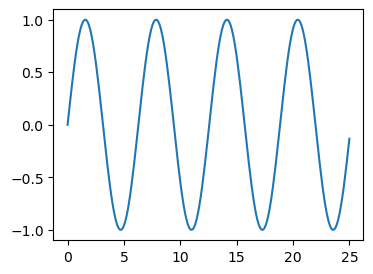

In [382]:
x = np.linspace(0,25, 200)
y = [np.sin(i) for i in x]
w = [1 for i in x]
df2 = pd.DataFrame({'x':x, 'y':y, 'w':w, 'const':w})

plt.figure(figsize=(4,3))
plt.plot(df2['x'], df2['y'])

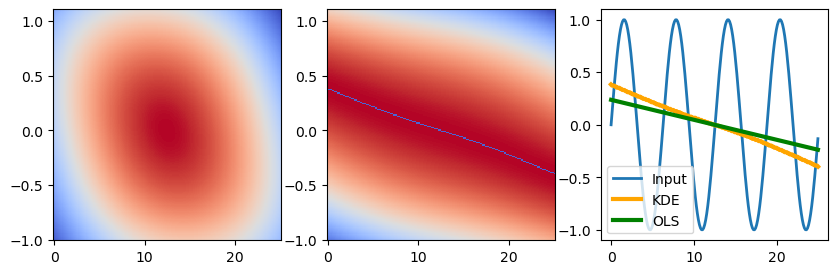

In [383]:

bandwidth = 1 # <-- Note the bandwidth number here

fig, ax = plt.subplots(1,3, figsize=(10,3), facecolor='white')

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df2, 'x', 'y', x_resolution, y_resolution, 0.001, forced_y_max=1.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df2['w'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 2
X, Y, x_array, y_array, positions = get_kde_matrices(df2, 'x', 'y', x_resolution, y_resolution, 0.001, forced_y_max=1.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df2['w'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 3
model = sm.OLS(df2['y'], df2[['const','x']])
results = model.fit()
b0,b1 = results.params.values[0], results.params.values[1]
y_reg = apply_reg(df2['x'], b0, b1)
ax[2].plot(df2['x'], df2['y'], linewidth=2, label='Input')
ax[2].plot(trend[0],trend[1], c='orange', linewidth=3, label='KDE')
ax[2].plot(df2['x'], y_reg, c='green', linewidth=3, label='OLS')

plt.legend()
plt.show()

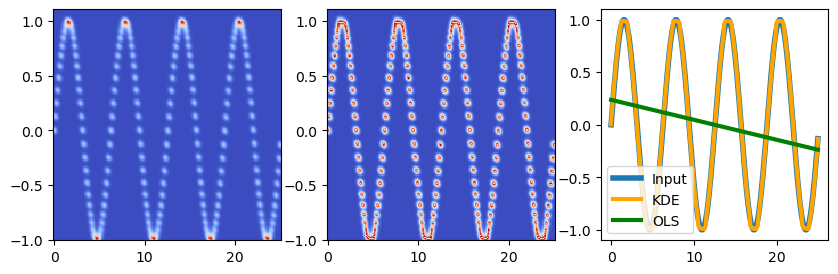

In [384]:
bandwidth = .03 # <-- Note the decreased bandwidth

fig, ax = plt.subplots(1,3, figsize=(10,3), facecolor='white')

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df2, 'x', 'y', x_resolution, y_resolution, 0.001, forced_y_max=1.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df2['w'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 2
X, Y, x_array, y_array, positions = get_kde_matrices(df2, 'x', 'y', x_resolution, y_resolution, 0.001, forced_y_max=1.1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df2['w'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 3
model = sm.OLS(df2['y'], df2[['const','x']])
results = model.fit()
b0,b1 = results.params.values[0], results.params.values[1]
y_reg = apply_reg(df2['x'], b0, b1)
ax[2].plot(df2['x'], df2['y'], linewidth=4, label='Input')
ax[2].plot(trend[0],trend[1], c='orange', linewidth=3, label='KDE')
ax[2].plot(df2['x'], y_reg, c='green', linewidth=3, label='OLS')

plt.legend()
plt.show()

# Real-world Problem

### Data Import

ID         x        y1  y1_weight        y2  y2_weight        y3  \
0  30340  5.031820  0.395242   0.000411  0.478392   0.001758  0.826188   
1  48700  5.058160  0.309311   0.000821  1.000000   0.000586  0.309311   
2  17420  5.088359  0.454698   0.000726  0.368015   0.001172  1.235543   
3  24020  5.099998  0.373157   0.001042  0.131020   0.001172  2.848096   
4  43300  5.117318  0.298623   0.000663  1.000000   0.000586  0.298623   

   y3_weight  const  
0   0.000380      1  
1   0.003396      1  
2   0.000233      1  
3   0.000010      1  
4   0.002829      1

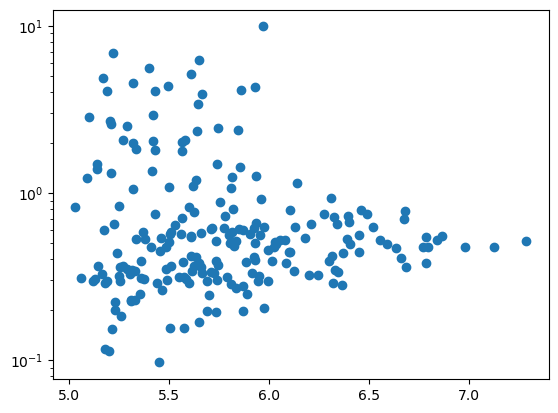

In [385]:
df = pd.read_csv('dataset_sample.csv')
display(df.head())
plt.scatter(df['x'], df['y3'])
plt.yscale('log')

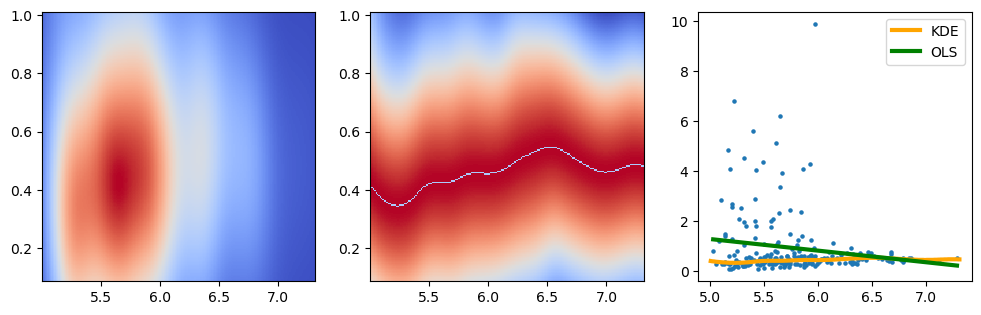

In [394]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5), facecolor='white')

bandwidth = 0.25

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y3', x_resolution, y_resolution, 0.01, forced_y_max=1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['const'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 2
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y3', x_resolution, y_resolution, 0.01, forced_y_max=1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['const'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# OLS 
model = sm.OLS(df['y3'], df[['const','x']])
results = model.fit()
b0,b1 = results.params.values[0], results.params.values[1]
y_ols = apply_reg(df['x'], b0, b1)

# Subplot 3
ax[2].plot(trend[0],trend[1], c='orange', linewidth=3, label='KDE')
ax[2].scatter(df['x'], df['y3'], s=5)
ax[2].plot(df['x'], y_ols, c='green', linewidth=3, label='OLS')

plt.legend()
plt.show()

# Lesson learned:

The data appeared to have an underlying trend of growth, especially when we considered the underlying sample-sizes of each 'point' in the scatter plot. Filtering poorly-sampled points led to increasingly strong KDE results. 

This was not an ideal solution: the sampling problem _really_ indicated introducing weights! 

Compare the following example, with weighted-KDE and weighted least-squares regression, to the prior results:

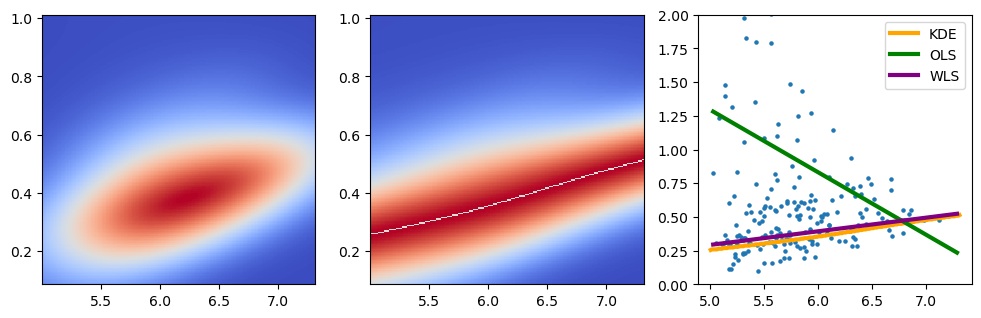

In [393]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5), facecolor='white')

bandwidth = 0.75

# Subplot 1
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y3', x_resolution, y_resolution, 0.01, forced_y_max=1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['y3_weight'], x_array, y_array, positions,)
ax[0].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# Subplot 2
X, Y, x_array, y_array, positions = get_kde_matrices(df, 'x', 'y3', x_resolution, y_resolution, 0.01, forced_y_max=1)
X, Y, Z, trend = generate_KDE_adj_w(bandwidth, X, Y, df['y3_weight'], x_array, y_array, positions, normalize=norm_plot, contrast_trend=contrast_trend)
ax[1].pcolormesh(X,Y,Z,cmap='coolwarm',shading='auto')

# OLS 
model = sm.OLS(df['y3'], df[['const','x']])
results = model.fit()
b0,b1 = results.params.values[0], results.params.values[1]
y_ols = apply_reg(df['x'], b0, b1)

# WLS
model_wls = sm.WLS(df['y3'], df[['const','x']], weights=df['y3_weight'])
res_wls = model_wls.fit()
y_wls = res_wls.fittedvalues

# Subplot 3
ax[2].plot(trend[0],trend[1], c='orange', linewidth=3, label='KDE')
ax[2].scatter(df['x'], df['y3'], s=5)
ax[2].plot(df['x'], y_ols, c='green', linewidth=3, label='OLS')
ax[2].plot(df['x'], y_wls, c='purple', linewidth=3, label='WLS')
ax[2].set_ylim(0,2)

plt.legend()
plt.show()

Notably, KDE still outperforms WLS in terms of the strength of the slope. We are still utilizing it, but there are challenges:

1. Estimates of error are challenging to analytically calculate: we are bootstrapping them. 
2. It is a less-common method, so it requires more explanation to share findings
3. KDE requires a bandwidth parameter which requires justification and stability to report findings, or the use of a well-known method of optimization. 
4. Data with a bound distribution requires special handling: typically this is done with simple adjustments like reflection. There is a mirroring function in the helpers as an example. 

Benefits of KDE include

1. It is a non-parametric model. If there are multiple true modes in a dataset, this method can handily beat traditional regression methods
2. KDE can much more easily fit non-monotonic relationships than typical regressions